In [3]:
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import torch.nn.functional as F
from tqdm.notebook import tqdm
import math
from IPython.display import clear_output
from gymnasium.wrappers import AtariPreprocessing

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = deque(maxlen=max_capacity)
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        self.buffer.append([state,action,reward,next_state,done])
    def clear_histoy(self):
        self.buffer.clear()
        
    def get_batch(self):
        state,action,reward,next_state,done = zip(*random.sample(self.buffer,self.batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    
    def __len__(self):
        return len(self.buffer)
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    

# CartPole

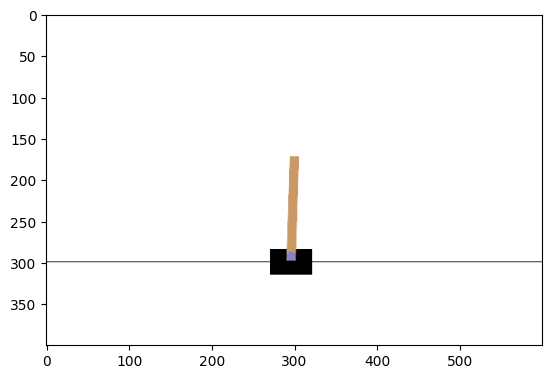

In [7]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [121]:
class DQN(nn.Module):
    def __init__(self,n_states,n_actions):
        super(DQN,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(n_states,64),
            nn.ReLU(),
        )
        self.value = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.action_value = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,n_actions)
        )

    def forward(self,state):
        x = self.f(state)
        v = self.value(x)
        a = self.action_value(x) - self.action_value(x).mean()
        x = v+a
        return x
    


In [122]:
Q = DQN(4,2).to(device)
static_Q = DQN(4,2).to(device)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

In [123]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [124]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
def train(Q,static_Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 1e-4,start_train_at = 10000,avg_reward_for_solved=450,averaging_last=200):

    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    epsilon = 1.0
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        epsilon = epsilon_by_frame(t)
        action = select_action(state,epsilon)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > start_train_at:
            s,action,reward,next_state,done = replay_buffer.get_batch()
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward).to(device)
            next_state = torch.from_numpy(next_state).unsqueeze(dim=1).type(torch.float32).to(device)
            not_done =torch.tensor(1-np.array(done)).to(device)
            next_max_value_action = torch.argmax(Q(next_state),dim=1)
            target = reward + not_done * gamma*static_Q(next_state).detach()[range(len(next_max_value_action)),next_max_value_action]
            prediction = Q(s)
            prediction = prediction[range(len(action)),action]
            loss = torch.nn.functional.mse_loss(prediction,target,reduction='mean')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if t % 200 == 0:
                static_Q.load_state_dict(Q.state_dict())
        if np.mean(reward_per_t[-averaging_last:]) > avg_reward_for_solved:
            print('Solved')
            break
        if t % 10000 == 0:
            plot(t,reward_per_t,losses)
            print(f'epsilon {epsilon:.2f}')

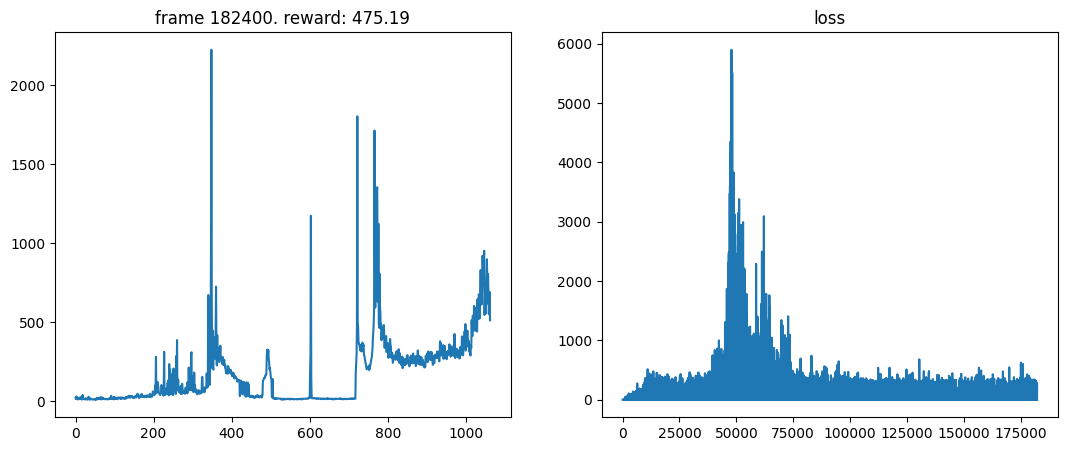

DONE


In [125]:
train(Q,static_Q,100000,env,batch_size=4,replay_buffer_size=1000,gamma=0.99,lr=5e-4,avg_reward_for_solved=450,averaging_last=200,start_train_at=1000)

In [128]:
# env_2 = gym.make('CartPole-v1',render_mode = 'human')
# #env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
# for episode in range(5):
#     state,info = env_2.reset()
#     rewards = 0
#     while True:
#         action = select_action(state,epsilon=0)
#         next_state,reward,done,_,info = env_2.step(action)
#         if done:
#             break
#         state = next_state
#         rewards+= reward
#     print('rewad',rewards)
# env_2.close()

# Atari Pong

actions Discrete(6)
observation Box(0, 255, (210, 160, 3), uint8)


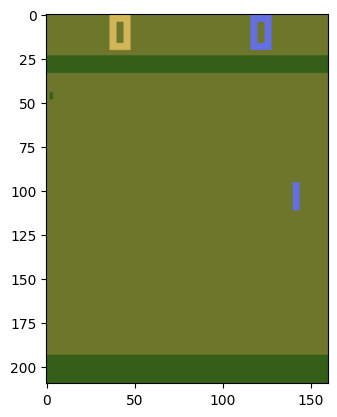

In [37]:
env = gym.make('PongNoFrameskip-v4',render_mode = 'rgb_array')
state,info = env.reset()
print('actions',env.action_space)
print('observation',env.observation_space)
plt.imshow(env.render())
plt.show()

In [38]:
class ConvDQN(nn.Module):
    def __init__(self,n_actions):
        super(ConvDQN,self).__init__()
        self.q = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=8,stride=4),
            nn.ReLU(),
        )
        self.value = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592,256),
            nn.ReLU(),
            nn.Linear(256,1)
        )
        self.action_value = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592,256),
            nn.ReLU(),
            nn.Linear(256,n_actions)
        )
        
    def forward(self,state):
        x = self.q(state)
        v = self.value(x)
        a = self.action_value(x) - self.action_value(x).mean()
        x = v+a
        return x

In [39]:
def select_action(state,epsilon = 1e-6):
    
    state = torch.from_numpy(state).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    
    if random.random() < epsilon:
        return random.randrange(env.action_space.n)
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [40]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 40000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [41]:
env = AtariPreprocessing(env,scale_obs=True,grayscale_newaxis=False,grayscale_obs=True)

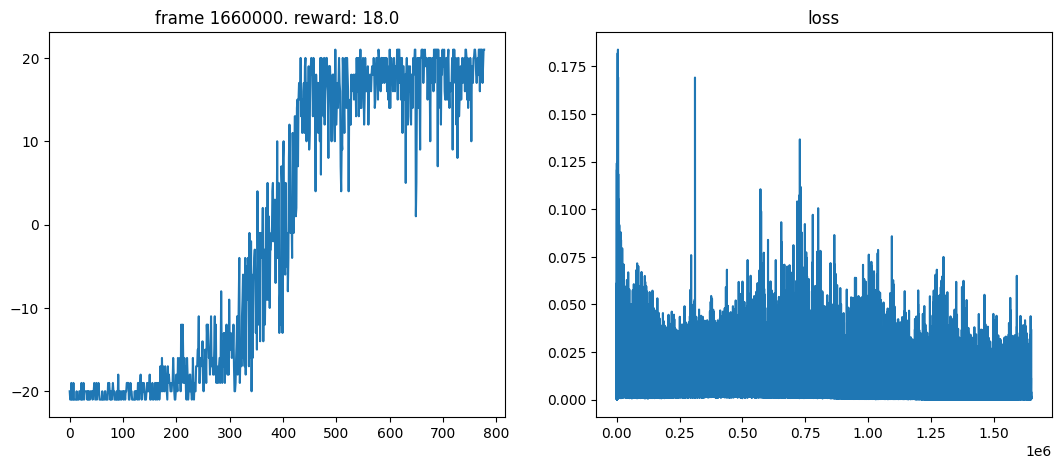

epsilon 0.01
Solved


In [47]:
train(Q,static_Q,10000000,env,batch_size=4,replay_buffer_size=100000,gamma=0.99,lr=5e-4,avg_reward_for_solved=20,averaging_last=20,start_train_at=10000)